In [4]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['../'])

Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0] on linux


In [5]:
import numpy as np
from scripts.data_utils import load_data, get_random_split, get_connectome

from scripts.classification_models import LogRegPCA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# Данные

Предлагаем два датасета: данные исследований Института мозга человека РАН (ИМЧ РАН) и открытый датасет Пекинского педагогического университета. Данные обоих датасетов представляют собой сканы функционального МРТ (фМРТ) в двух состояниях - закрытые и открытые глаза.

Функциональная магнитно-резонансная томография (фМРТ) — это метод нейровизуализации, который позволяет исследовать активность мозга. В отличие от обычной МРТ, которая создает снимки структуры мозга, фМРТ фиксирует изменения, связанные с нейронной активностью.

### Как работает фМРТ:
Метод основывается на так называемом BOLD-сигнале (Blood Oxygen Level Dependent). Когда определенные участки мозга активны, они потребляют больше кислорода. Кровь с высоким содержанием кислорода и с низким содержанием имеют разные магнитные свойства. Это различие и регистрируется фМРТ-сканером. В результате можно узнать, какие области мозга становятся активными в ответ на различные стимулы или задачи. Данные, получаемые на выходе - 3D изображения мозга, где каждому вокселю соответствует временной ряд, показывающий изменение уровня кислорода в крови с течением времени.

In [18]:
import nibabel as nib
import nilearn

In [28]:
fmri_img_path = '/arch/OpenCloseProject/derivatives/sub-001/func/sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
fmri_img = nib.load(fmri_img_path)

# преобразование в numpy.array
img_array = fmri_img.get_fdata()

# первые три размерности - изображение, 
# четвертая - временной ряд, изменение изображения во времени
fmri_img.shape

(120, 142, 50, 120)

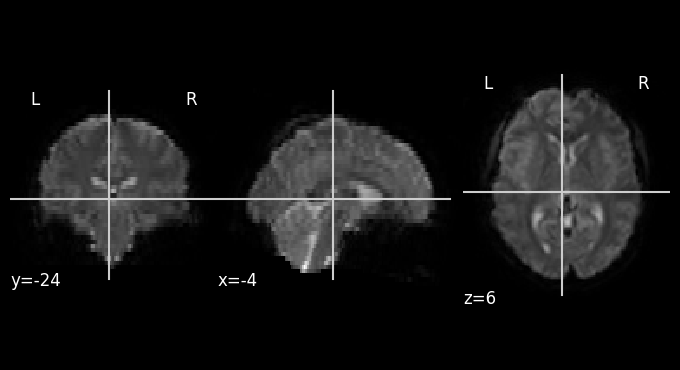

In [25]:
# визуализация фМРТ изображения на 40 временной точке
img_slice = fmri_img.slicer[:, :, :, 40]
nilearn.plotting.plot_img(img_slice, cmap='gray', black_bg=True);

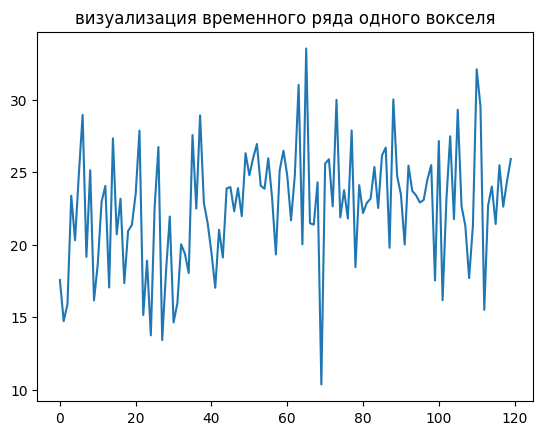

In [30]:
# теперь наоборот - визуализация временного ряда одного вокселя
plt.plot(img_array[30, 15, 22, :])
plt.title('визуализация временного ряда одного вокселя');

# Постановка задачи

ФМРТ применяется в различных областях, включая медицину (диагностика и планирование лечения различных неврологических и психиатрических расстройств, таких как эпилепсия, шизофрения и другие) и нейрофизиологию (изучение работы мозга, исследование процессов, таких как память, внимание, язык). 

Используя данные датасеты, мы хотим изучать влияние закрытия и открытия глаз на активность мозга. Почему это важно? Когда человек лежит в МРТ сканере с открытыми или закрытыми глазами -- это называют МРТ в состоянии оперативного покоя. Его делают всегда перед операцией и для диагностики заболеваний. При этом нет определенного вывода о том, в каком состоянии лучше проводить сканирование, так как разные исследования часто описывают различающиеся результаты. С другой стороны, много всего известно про оба состояния и их различия в здоровом мозге, что дает нам хороший бейзлайн для валидирования ML моделей. То есть если модели научатся правильно и эффективно различать открытые и закрытые глаза -- мы сможем двинуться дальше к использованию машинного обучения на намного более сложных данных больных людей. Здесь очень важен этап интерпретации результатов работы моделей, чтобы для классификации они использовали не какие-то особенности изображений (например, шум), а реальные различия между состояниями, которые могут быть обоснованы с физиологической точки зрения.

# Обработка данных

Из-за того, что размерность исходных фМРТ данных довольно велика (120 * 142 * 50 вокселей в нашем случае), принято уменьшать размерность используя, например, атласы мозга. С помощью атласов воксели объединяются в регионы, соответствующие структурам мозга, а временные серии усредняются по всем вокселям, включенным в регион. 

Здесь мы предлагаем использовать атлас [HCPex](https://github.com/wayalan/HCPex), в котором 426 регионов, включая 66 подкорковых.  

Таблица с информацией об атласе:

- **ID**: в таблице есть два столбца с ID. Разница между ними в сортировке. `HCPex_ID` сортирует строки в порядке, данном в файле атласа HCPex, то есть сначала указаны все регионы левого полушария (`Primary_Visual_Cortex_L` - L значит левое полушарие), потом правого. `SORTED_ID` сортирует строки в порядке *левый регион-правый регион* (`Primary_Visual_Cortex_L`, `Primary_Visual_Cortex_R`, ...)
- **Label**: название региона и короткая форма названия
- **Cortical division**: к какой структуре мозга относится регион
- **Functional network**: к какой функциональной сети относится регион, на основе статей авторов [Cole и Anticevic](https://github.com/ColeLab/ColeAnticevicNetPartition)

In [41]:
import pandas as pd

hcp_table = pd.read_excel('/home/tm/projects/OpenCloseBaseline/HCPex_Atlas_Description.xlsx', 
                          index_col='HCPex_ID').sort_index()
hcp_table.head()

,SORTED_ID,Label,Short_label,Cortical Division,Cortical_Division_Number,ColeAnticevic_functional_network,ColeAnticevic_functional_network_label
HCPex_ID,,,,,,,
1,1,Primary_Visual_Cortex_L,L_V1,Primary_Visual,1,1,Visual1
2,3,Second_Visual_Area_L,L_V2,Early_Visual,2,2,Visual2
3,5,Third_Visual_Area_L,L_V3,Early_Visual,2,2,Visual2
4,7,Fourth_Visual_Area_L,L_V4,Early_Visual,2,2,Visual2
5,9,IntraParietal_Sulcus_Area_1_L,L_IPS1,Dorsal_Stream_Visual,3,2,Visual2


**Функциональные сети**

Функциональные сети мозга формируются благодаря взаимодействию различных участков мозга, которые координируются для выполнения конкретных когнитивных задач. Эти сети состоят из областей мозга, которые синхронно активируются и работают вместе для достижения общей цели, такой как восприятие, внимание, память или моторное управление. Функциональные сети формируются за счет синхронизации активности между различными областями мозга. Эта синхронизация может измеряться с помощью таких методов, как электроэнцефалография (ЭЭГ) или фМРТ. Часто синхронизация происходит на определенных частотах (например, альфа-ритм, бета-ритм и т.д.), что помогает различным областям мозга работать слаженно.
В мозге выделяют несколько ключевых функциональных сетей, каждая из которых отвечает за выполнение определенных функций. Например:
- Сеть пассивного режима работы (Default Mode Network, DMN) активируется, когда человек находится в состоянии покоя, размышляет или вспоминает.
- Сеть внимания (Attention Network) активируется при выполнении задач, требующих концентрации и фокусировки.
- Моторные и сенсорные сети (Somatomotor network) ответственны за контроль движений и обработку сенсорной информации.
- Зрительные сети (Visual Networks) отвечают за обработку зрительной информации.

In [45]:
hcp_table.ColeAnticevic_functional_network_label.value_counts()

ColeAnticevic_functional_network_label
Default                 77
Cingulo-Opercular       56
Visual2                 54
Frontoparietal          50
Thalamus                42
Somatomotor             39
Subcortical             24
Language                23
Dorsal-Attention        23
Auditory                15
Posterior-Multimodal     7
Visual1                  6
Orbito-Affective         6
Ventral-Multimodal       4
Name: count, dtype: int64

# Бейзлайн

Наиболее распространенный вариант работы с фМРТ данными в области машинного обучения -- использовать векторизованные матрицы связности (connectivity matrix) в качестве обучающих данных.

Матрицы функциональной связности показывают схожесть временных рядов двух регионов. Обычно выражается в коэффициенте корреляции. Идея в том, что если два региона работают вместе, то их сигналы будут похожи.

На вход модели подают матрицу, превращенную в длинный вектор.

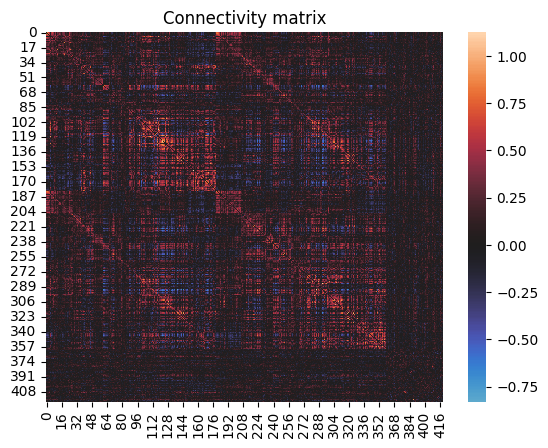

In [68]:
path_to_dataset = "/data/Projects/OpenCloseIHB/ihb_dataset.hdf5"
X, _, _ = load_data(path_to_dataset)

# функция для вычисления матриц связности
cm = get_connectome(X)

# нарисуем матрицу связности для первого человека
sns.heatmap(cm[0], center=0)
plt.title('Connectivity matrix');

## Датасет ИМЧ РАН

Данные ИМЧ РАН представляют собой сканы функционального МРТ в двух состояниях (закрытые и открытые глаза) для 84 человек (т.е. всего 168 сканов в датасете).

HDF5 файл состоит из 84 папок для каждого испытуемого. Внутри папок два массива -- для закрытых и открытых глаз, каждый размерности `(120, 420)`, где 120 - количество временных точек, а 420 - количество регионов интереса. В данных количество регионов меньше, чем в атласе, так как из-за качества получившихся сканов из некоторых регионов просто не получилось вытащить сигнал (регионы `365, 372, 396, 398, 401, 405` по индексу `HCPex_ID`)

In [70]:
path_to_dataset = "/data/Projects/OpenCloseIHB/ihb_dataset.hdf5"

# единичный сплит
X, y, groups = load_data(path_to_dataset)
X_train, X_test, y_train, y_test, train_groups, test_groups = get_random_split(X, y, groups, 
                                                                               test_size=0.15, random_state=6)

In [53]:
logreg = LogRegPCA()
logreg.model.set_params(**{'C': 0.0002})
logreg.pca.set_params(**{'n_components': 0.80})


train_acc = logreg.model_training(X_train, y_train)
conf_mat, acc = logreg.model_testing(X_test, y_test)

Accuracy on train: 0.894
Accuracy on test: 0.731


### Интерпретация

## Датасет Пекин

Датасет Пекинского университета состоит из двух сканов в состоянии закрытых глаз и одного скана с открытыми глазами для 48 испытуемых. HDF5 файл состоит из 48 папок для каждого испытуемого. 

Папки названы в соответствии с id испытуемого. Далее внутри папок испытуемых лежат 3 массива. В этом датасете 3 скана: 2 для закрытых и 1 для открытых. При этом  у всех людей первая сессия -- закрытые глаза, а остальные сессии разнятся (то есть 2 сессия может быть тоже при закрытых глазах, 3 - при открытых). Это указано в названии. 

Особенность датасета - для двух людей удалены по одному скану из-за плохого качества данных (для sub-3258811 закрытые глаза, 3 сессия, и для sub-2021733 открытые глаза, 2 сессия).

In [55]:
path_to_dataset = "/data/Projects/OpenCloseChina/china_dataset.hdf5"

# единичный сплит
X, y, groups = load_data(path_to_dataset)
X_train, X_test, y_train, y_test, train_groups, test_groups = get_random_split(X, y, groups, 
                                                                               test_size=0.15, random_state=6)

In [56]:
logreg = LogRegPCA()
logreg.model.set_params(**{'C': 0.0002})
logreg.pca.set_params(**{'n_components': 0.8})

train_acc = logreg.model_training(X_train, y_train)
conf_mat, acc = logreg.model_testing(X_test, y_test)

Accuracy on train: 0.771
Accuracy on test: 0.792


### Интерпретация